# Importação das Bibliotecas

In [ ]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import pytensor.tensor as tt

# Importação da base de dados

In [ ]:
# Carregamento dos dados a partir de um arquivo CSV localizado no Google Drive.
original = pd.read_csv('./staging/porto_ts.csv')

In [ ]:
original

,ano,mes,porto,graos,outras,sugar
0,2005,1,5027941,412400,1780376,581383
1,2005,2,5316605,707274,1821686,878016
2,2005,3,5899912,1221079,1917759,610140
3,2005,4,5850639,1301598,1976311,764285
4,2005,5,6826372,1575474,2122232,1007705
...,...,...,...,...,...,...
211,2022,8,14626790,4122517,3188229,2455597
212,2022,9,13628567,3743920,3258989,2079487
213,2022,10,14435751,4185655,3198681,2249483
214,2022,11,12194409,3459541,2558110,2199680


### Alguns ajustes para o projeto atual

In [ ]:
# remoção de colunas desnecessárias
original.drop(['graos','outras','sugar'], axis=1, inplace=True)

In [ ]:
original

,ano,mes,porto
0,2005,1,5027941
1,2005,2,5316605
2,2005,3,5899912
3,2005,4,5850639
4,2005,5,6826372
...,...,...,...
211,2022,8,14626790
212,2022,9,13628567
213,2022,10,14435751
214,2022,11,12194409


In [ ]:
# Conversão das colunas 'ano' e 'mes' para um índice datetime.
original['data'] = pd.to_datetime(original['ano'].astype(str) + '-' + original['mes'].astype(str), format='%Y-%m')
original['lastDay'] = original['data'] + pd.offsets.MonthBegin(0)   # set a data no início do mês
#original['lastDay'] = original['data'] + pd.offsets.MonthEnd(0)    # set a data no final do mês

original['data'] = original['lastDay'].dt.strftime("%Y-%m-%d")
original.drop(['lastDay'], axis=1, inplace=True)
original['data'] = pd.to_datetime(original['data'])
print(original)

      ano  mes     porto       data
0    2005    1   5027941 2005-01-01
1    2005    2   5316605 2005-02-01
2    2005    3   5899912 2005-03-01
3    2005    4   5850639 2005-04-01
4    2005    5   6826372 2005-05-01
..    ...  ...       ...        ...
211  2022    8  14626790 2022-08-01
212  2022    9  13628567 2022-09-01
213  2022   10  14435751 2022-10-01
214  2022   11  12194409 2022-11-01
215  2022   12  12096270 2022-12-01

[216 rows x 4 columns]


In [ ]:
data_orig = original.data[:len(original)]    # verificar
data_orig

0     2005-01-01
1     2005-02-01
2     2005-03-01
3     2005-04-01
4     2005-05-01
         ...    
211   2022-08-01
212   2022-09-01
213   2022-10-01
214   2022-11-01
215   2022-12-01
Name: data, Length: 216, dtype: datetime64[ns]

## Normalização da data


In [ ]:
min_month = original.index.min()
max_month = original.index.max()
print(min_month, max_month)
data_std = (original.index - min_month)/(max_month-min_month)
original['data_std'] = data_std

0 215


## Normalização da movimentação

In [ ]:
maximo_mov = original.porto.max()
minimo_mov = original.porto.min()
print(maximo_mov, minimo_mov)
mov_std = (original.porto - minimo_mov) / (maximo_mov - minimo_mov)
original['porto_std'] = mov_std
original

15165869 4588410


,ano,mes,porto,data,data_std,porto_std
0,2005,1,5027941,2005-01-01,0.000000,0.041554
1,2005,2,5316605,2005-02-01,0.004651,0.068844
2,2005,3,5899912,2005-03-01,0.009302,0.123990
3,2005,4,5850639,2005-04-01,0.013953,0.119332
4,2005,5,6826372,2005-05-01,0.018605,0.211578
...,...,...,...,...,...,...
211,2022,8,14626790,2022-08-01,0.981395,0.949035
212,2022,9,13628567,2022-09-01,0.986047,0.854662
213,2022,10,14435751,2022-10-01,0.990698,0.930974
214,2022,11,12194409,2022-11-01,0.995349,0.719076


## Gerando dataframe apenas com dados necessários

In [ ]:
original_std = original[['data_std', 'porto_std']]
original_std.index = original_std.data_std
original_std.drop(['data_std'], axis=1,inplace=True)
original_std

<ipython-input-12-66111c678ec3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_std.drop(['data_std'], axis=1,inplace=True)


,porto_std
data_std,
0.000000,0.041554
0.004651,0.068844
0.009302,0.123990
0.013953,0.119332
0.018605,0.211578
...,...
0.981395,0.949035
0.986047,0.854662
0.990698,0.930974


# Divisão dos dados em Treino / Teste  aproximadamente 80%

In [ ]:
# Definindo os dados para treinamento
d = original.data.values.T
# normalizado
x = original_std.index.values.T
y = original_std.porto_std.values.T

# percentual para treinamento
perc = 0.8                          # o mais próximo possível
periodo = int(len(x) * perc // 12)       # período em anos
n = periodo * 12
treino_split = n-1       # anos para treino /total

# Exibindo a divisão de dados para treino
print(f'{n} meses\n{n/12} anos\n{treino_split/216*100:.2f} %')
more_months = len(d) - n
print(more_months)

168 meses
14.0 anos
77.31 %
48


In [ ]:
# Final do período de treino
original.iloc[treino_split]

ano                         2018
mes                           12
porto                   10863015
data         2018-12-01 00:00:00
data_std                0.776744
porto_std               0.593205
Name: 167, dtype: object

In [ ]:
# separação treino/teste
x_treino = x[ :treino_split+1]
x_teste  = x[treino_split+1: ]

y_treino = y[:treino_split+1]
y_teste  = y[treino_split+1:]

d_treino = d[:treino_split+1]
d_teste  = d[treino_split+1: ]

In [ ]:
print(len(x_treino), len(y_treino), len(x_teste), len(y_teste))

168 168 48 48


In [ ]:
#x_treino
#x_teste
#y_treino
y_teste

array([0.41544099, 0.51814968, 0.64249835, 0.57047983, 0.6055651 ,
       0.66068353, 0.77338206, 0.70899599, 0.65999821, 0.77529149,
       0.60890163, 0.53158296, 0.35217721, 0.57364165, 0.77605103,
       0.8415212 , 0.80086976, 0.73515047, 0.84843212, 0.86455537,
       0.71691055, 0.74599126, 0.71206553, 0.68780479, 0.43526049,
       0.59929223, 1.        , 0.86706268, 0.89786309, 0.82046662,
       0.76002526, 0.7069229 , 0.68669252, 0.58038448, 0.62902461,
       0.71229858, 0.57778763, 0.78576679, 0.99933207, 0.87020758,
       0.91222703, 0.90346642, 0.94496306, 0.94903511, 0.85466245,
       0.93097416, 0.7190762 , 0.70979807])

[Text(0.5, 1.0, 'Separação Treino / Teste'),
 Text(0.5, 0, 't'),
 Text(0, 0.5, '')]

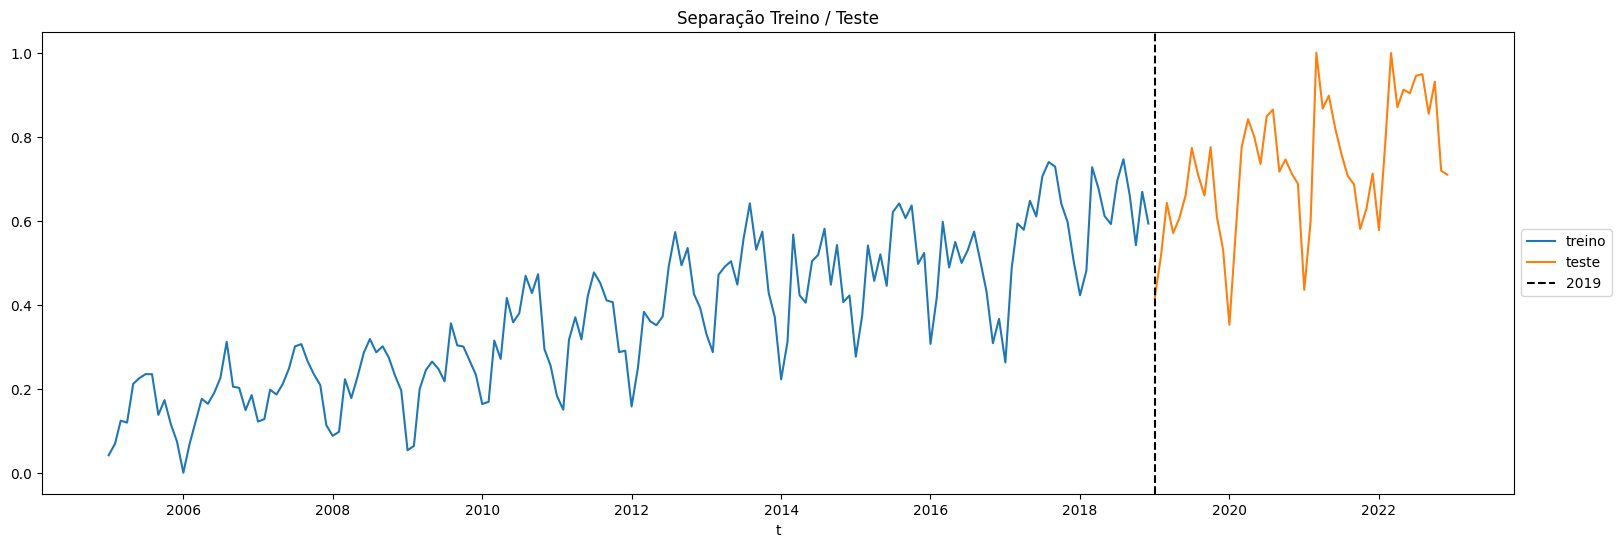

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(19,6))
sns.lineplot(x=d_treino.flatten(), y=y_treino.flatten(), label='treino', ax=ax)
sns.lineplot(x=d_teste.flatten(), y=y_teste.flatten(), label='teste', ax=ax)
ax.axvline(x=d_teste.flatten()[0], linestyle='--', label='2019', color='black')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Separação Treino / Teste', xlabel='t', ylabel='')

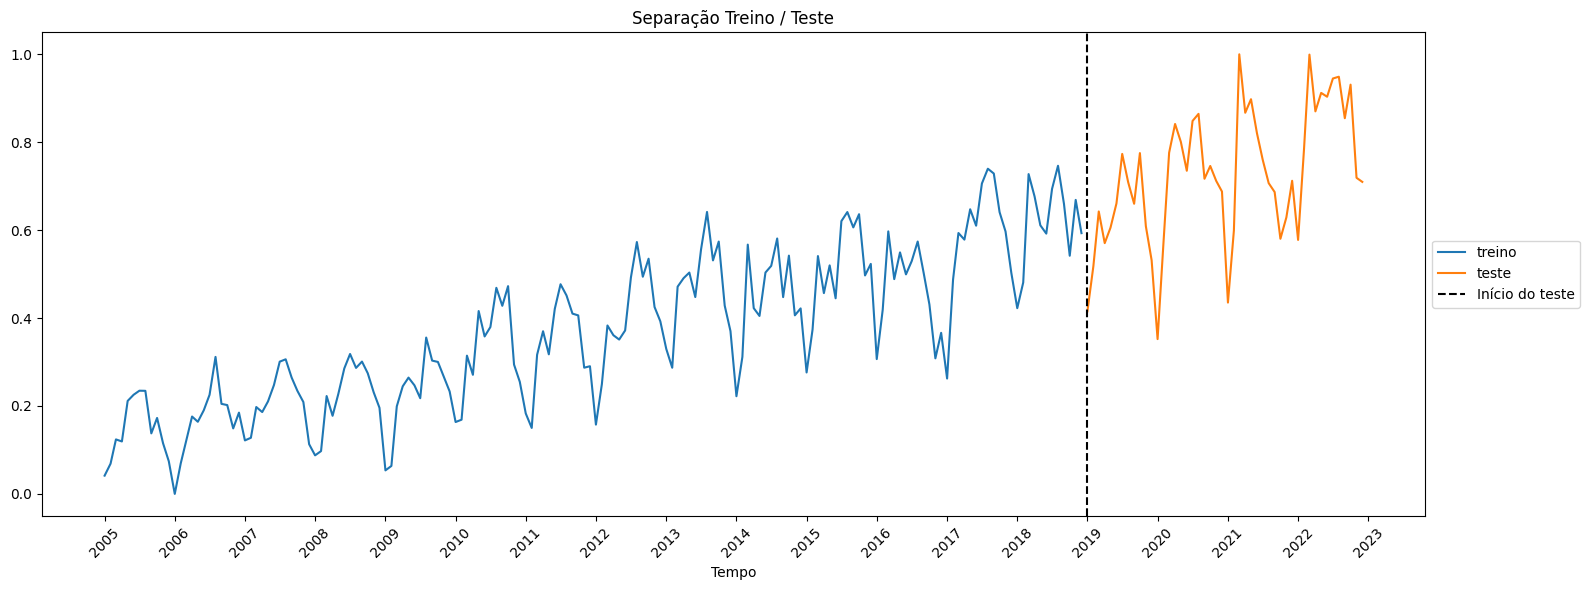

In [ ]:
import matplotlib.dates as mdates

#Supondo que x_treino e x_teste sejam arrays de datas
fig, ax = plt.subplots(figsize=(16,6))

sns.lineplot(x=d_treino, y=y_treino, label='treino', ax=ax)
sns.lineplot(x=d_teste, y=y_teste, label='teste', ax=ax)

# Adicionando linha de separação entre treino e teste
ax.axvline(x=d_teste[0], linestyle='--', label='Início do teste', color='k')

# Configurando formatação do eixo x para datas mensais
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1]))

# Rotacionando os rótulos do eixo x
plt.xticks(rotation=45)

# Configurando a legenda
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Definindo títulos e rótulos
ax.set(title='Separação Treino / Teste', xlabel='Tempo', ylabel='')

plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

# Modelo  Prophet - Cosine

usando uma função de covariância com  cosine kernel

In [ ]:
with pm.Model() as model_3:

    l_ratquad = pm.HalfNormal('l_ratquad', sigma=4)
    alpha_ratquad = pm.HalfNormal('alpha_ratquad', sigma=4)
    sigma_ratquad = pm.HalfNormal('sigma_ratquad', sigma=4)

    l_cosine = pm.HalfNormal('l_cosine', sigma=0.5)
    sigma_cosine = pm.HalfNormal('sigma_cosine', sigma=0.5)

    cov_ratquad = sigma_ratquad * pm.gp.cov.RatQuad(1, l_ratquad, alpha_ratquad)
    cov_cosine = sigma_cosine * pm.gp.cov.Cosine(1, l_cosine)

    cov = cov_ratquad + cov_cosine

    a = pm.Normal("a",0.15,1)
    b = pm.Normal("b",0.8,0.125)
    #trend = pm.Deterministic("trend", a + b * x_treino)
    M = pm.gp.mean.Linear([b], a)

    gp = pm.gp.Marginal(mean_func = M, cov_func=cov)
    sigma = pm.HalfNormal('sigma', sigma=1)
    y_obs = gp.marginal_likelihood('y', X=x_treino.reshape(-1,1),y=y_treino, noise=sigma)


/usr/local/lib/python3.10/dist-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


## Preditiva a priori

Para ajustar os parâmetros

In [ ]:
with model_3:
  prior_3 = pm.sample_prior_predictive()

<ipython-input-45-b9188df45198>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(prior_3, group="prior_predictive", num_samples=100)["y"]
<ipython-input-45-b9188df45198>:13: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(prior_3, group="prior", num_samples=100)["trend"] * y_treino.max(),


Text(0.5, 1.0, 'Prior trend lines')

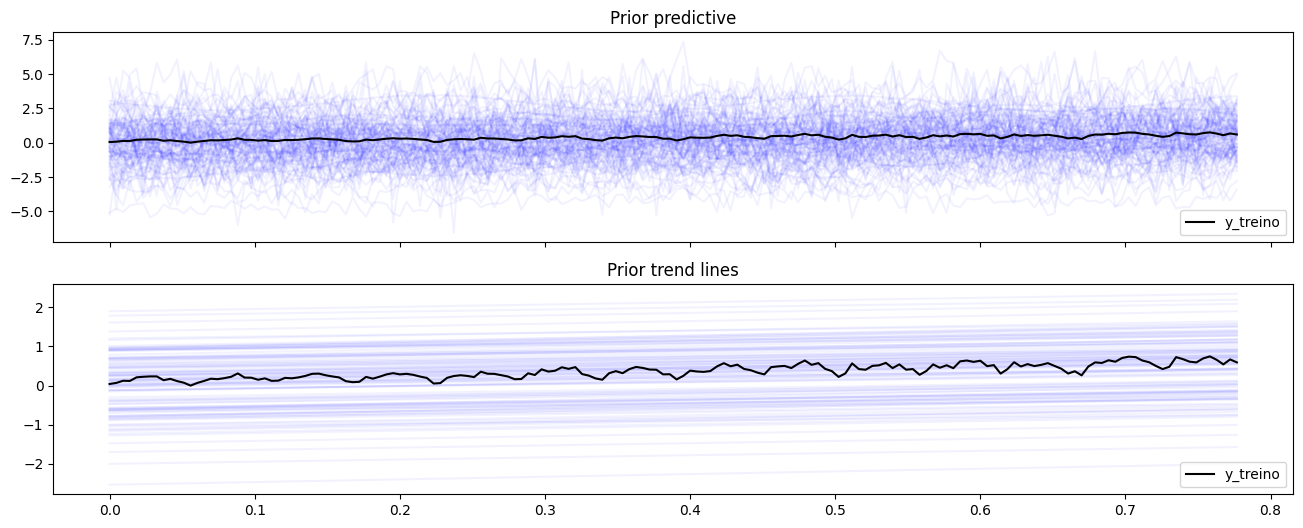

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(16,6))
ax[0].plot(
    x_treino,
    az.extract_dataset(prior_3, group="prior_predictive", num_samples=100)["y"]
    * y_treino.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_treino.flatten(), y=y_treino.flatten(), color="k", label='y_treino', ax=ax[0])
ax[0].set_title("Prior predictive")
ax[1].plot(
    x_treino,
    az.extract_dataset(prior_3, group="prior", num_samples=100)["trend"] * y_treino.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_treino.flatten(), y=y_treino.flatten(), color="k",label='y_treino', ax=ax[1])
ax[1].set_title("Prior trend lines")

In [ ]:
with model_3:

  trace_3 = pm.sample()

In [ ]:
pm.summary(trace_3)

In [ ]:
pm.model_to_graphviz(model_3)

In [ ]:
with model_3:
    x_teste_c = gp.conditional('x_teste', x_teste.reshape(-1,1))
    pred_m_3 = pm.sample_posterior_predictive(trace_3, var_names=["x_teste"])

In [ ]:
pred_m_3

<ipython-input-32-3419f8e8be96>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(pred_m_3, group="posterior_predictive", num_samples=200)["x_teste"],


Text(0.5, 1.0, 'Posterior predictive')

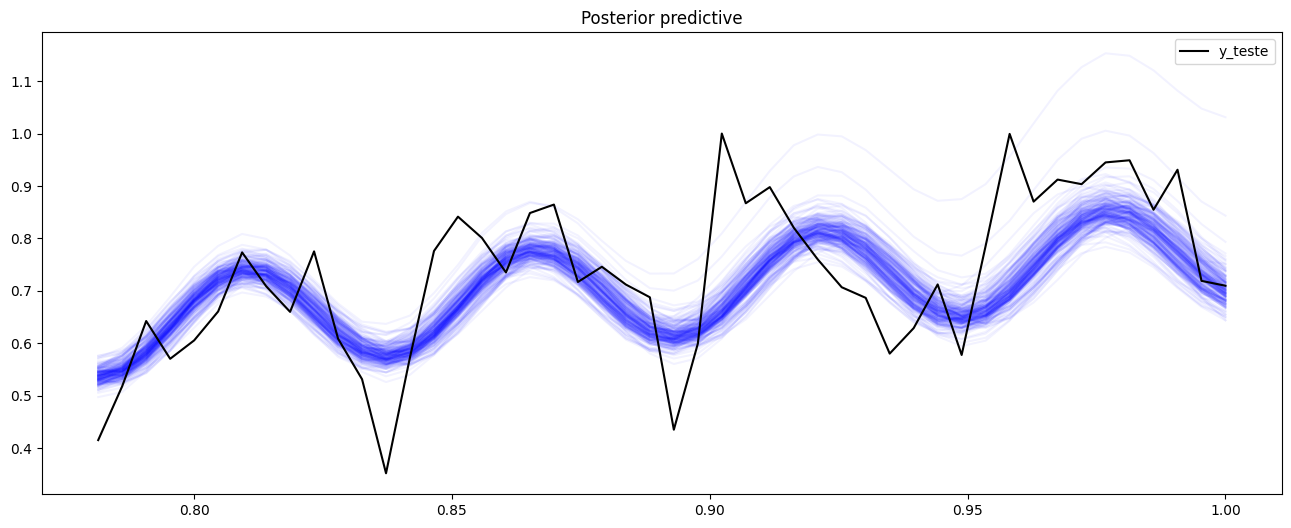

In [ ]:
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(
    x_teste,
    az.extract_dataset(pred_m_3, group="posterior_predictive", num_samples=200)["x_teste"],
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_teste.flatten(), y=y_teste.flatten(), color="k", label='y_teste', ax=ax)
ax.set_title("Posterior predictive")

In [ ]:
f_pred_samples_3 = az.extract(pred_m_3, group="posterior_predictive", var_names=["x_teste"])
f_pred_samples_3

<xarray.DataArray 'x_teste' (x_teste_dim_2: 48, sample: 2000)>
array([[0.52827884, 0.54221196, 0.55428571, ..., 0.52059137, 0.51701011,
        0.52953229],
       [0.54566779, 0.53984605, 0.5513638 , ..., 0.53589994, 0.54384499,
        0.54737671],
       [0.58176333, 0.56529596, 0.57328718, ..., 0.57352471, 0.58926653,
        0.58706182],
       ...,
       [0.73591113, 0.78579355, 0.8016033 , ..., 0.73429294, 0.70035402,
        0.74995388],
       [0.69363519, 0.74577832, 0.76326542, ..., 0.68921904, 0.66378106,
        0.70493972],
       [0.67094862, 0.71055634, 0.7273366 , ..., 0.66099593, 0.64843848,
        0.67765152]])
Coordinates:
  * x_teste_dim_2  (x_teste_dim_2) int64 0 1 2 3 4 5 6 ... 41 42 43 44 45 46 47
  * sample         (sample) object MultiIndex
  * chain          (sample) int64 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1
  * draw           (sample) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999

<Axes: >

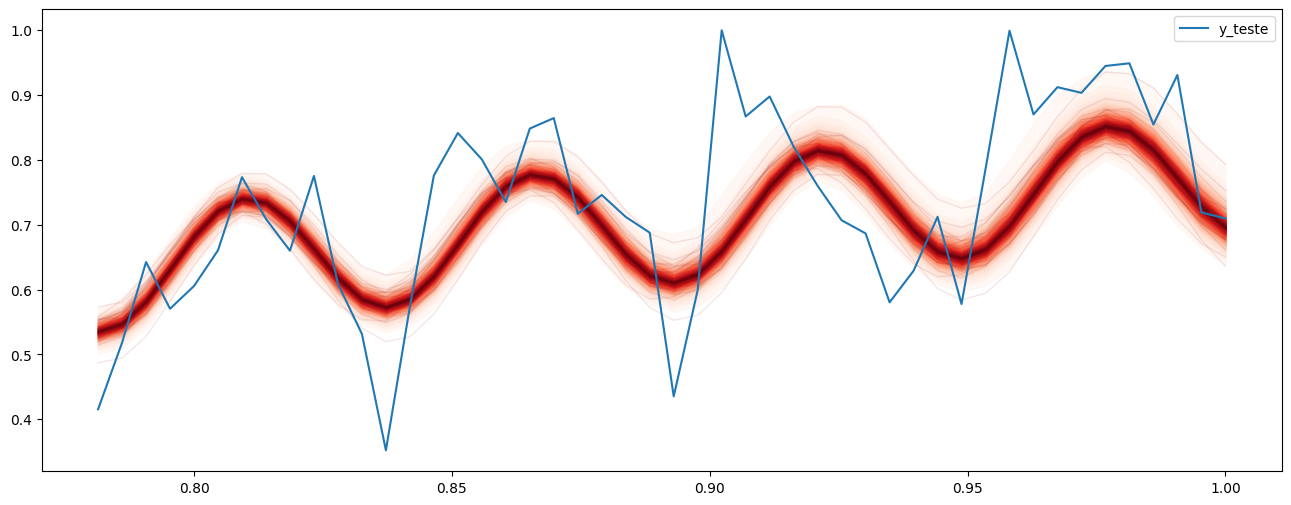

In [ ]:
from pymc.gp.util import plot_gp_dist

fig = plt.figure(figsize=(16,6)); ax = fig.gca()

plot_gp_dist(ax, f_pred_samples_3.T, x_teste);

sns.lineplot(x=x_teste.flatten(), y=y_teste.flatten(), label='y_teste', ax=ax)

In [ ]:
y_pred_3 = pred_m_3.posterior_predictive["x_teste"].values.mean(axis=1)[0]
print(f"MAE: {abs(y_pred_3 - y_teste).sum()/len(y_teste)}")

MAE: 0.08930173057475017
